# The Zen Performer®: Deep Coaching in Artificial Intelligence Neural Style    Transfer and Reinforcement Learning to Manage Emotions

In this notebook I will implement a style transfer technique, using the frameworks learned from ["Image Style Transfer Using Convolutional Neural Networks" (Gatys et al., CVPR 2015)](http://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf), RNN Captioning, Generative Adversarial Networks and Network Visualization.

The main idea is to take three images, and generate a new image based on the classification of the content image which can propagate different emotions, and then classify them in the corresponding emotional cluster. I have also reformulated a new loss function in order to improve my classification.

I will take two images, and produce a new image that reflects the content of one but the artistic "style" of the other. We will do this by first formulating a loss function that matches the content and style of each respective image in the feature space of a deep network, and then performing gradient descent on the pixels of the image itself.

The deep network we use as a feature extractor is [SqueezeNet](https://arxiv.org/abs/1602.07360), a small model that has been trained on ImageNet. You could use any network, but we chose SqueezeNet here for its small size and efficiency.

Here's an example of the images you'll be able to produce by the end of this notebook:

![caption](test_imageZP.png)


## Setup

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import PIL
import numpy as np
import time, os, json
import matplotlib.pyplot as plt


from scipy.misc import imread
from collections import namedtuple
import matplotlib.pyplot as plt
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.rnn_layers import *
from cs231n.captioning_solver import CaptioningSolver
from cs231n.classifiers.rnn import CaptioningRNN
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url
from cs231n.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
!pip install h5py

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
# Load COCO data from disk; this returns a dictionary
# I work with these datasets to review my overakll process

data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


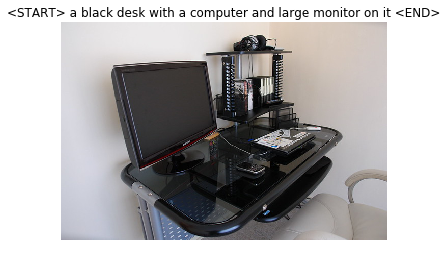

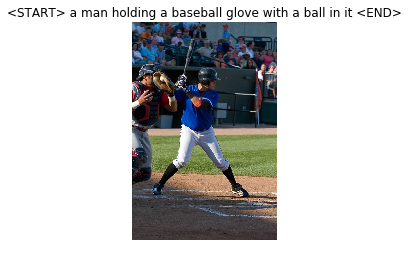

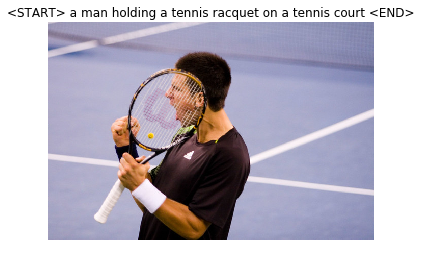

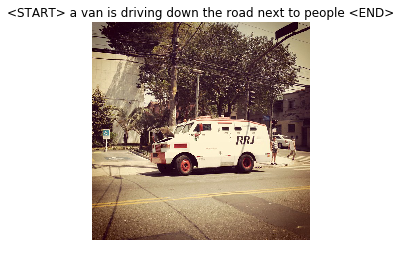

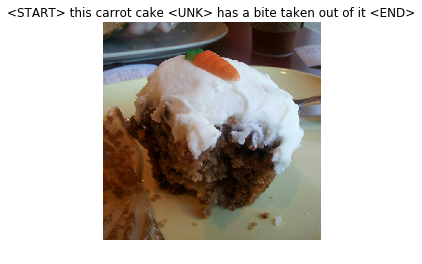

In [4]:
# Sample a minibatch and show the images and captions
batch_size = 5

captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
for i, (caption, url) in enumerate(zip(captions, urls)):
    plt.imshow(image_from_url(url))
    plt.axis('off')
    caption_str = decode_captions(caption, data['idx_to_word'])
    plt.title(caption_str)
    plt.show()

In [5]:
# Preprocessing
def preprocess(img, size=512):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[1.0 / s for s in SQUEEZENET_STD.tolist()]),
        T.Normalize(mean=[-m for m in SQUEEZENET_MEAN.tolist()], std=[1, 1, 1]),
        T.Lambda(rescale),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def features_from_img(imgpath, imgsize):
    img = preprocess(PIL.Image.open(imgpath), size=imgsize)
    img_var = img.type(dtype)
    return extract_features(img_var, cnn), img_var

# Check size
def check_scipy():
    import scipy
    vnum = int(scipy.__version__.split('.')[1])
    major_vnum = int(scipy.__version__.split('.')[0])
    
    assert vnum >= 16 or major_vnum >= 1

check_scipy()
answers = dict(np.load('style-transfer-checks.npz'))

In [6]:
dtype = torch.FloatTensor


In [7]:
# Pre-trained SqueezeNet Model Loading
cnn = torchvision.models.squeezenet1_1(pretrained=True).features
cnn.type(dtype)

# Break the training
for param in cnn.parameters():
    param.requires_grad = False

# Feature extractor throurg CNN
def extract_features(x, cnn):
    features = []
    prev_feat = x
    for i, module in enumerate(cnn._modules.values()):
        next_feat = module(prev_feat)
        features.append(next_feat)
        prev_feat = next_feat
    return features

## Computing Loss


## Loss computation

Loss formula is given by:

$L_c = w_c \times \sum_{i,j} (F_{ij}^{\ell} - P_{ij}^{\ell})^2$

In [8]:
def content_loss(content_weight, content_current, content_original):
    loss = content_weight * (content_current - content_original).pow(2).sum()
    return loss

In [9]:
def content_loss_test(correct):
    content_image = 'styles/SFSky.jpg'
    image_size =  192
    content_layer = 3
    content_weight = 6e-2
    
    c_feats, content_img_var = features_from_img(content_image, image_size)
    
    bad_img = torch.zeros(*content_img_var.data.size()).type(dtype)
    feats = extract_features(bad_img, cnn)
    
    student_output = content_loss(content_weight, c_feats[content_layer], feats[content_layer]).cpu().data.numpy()
    error = rel_error(correct, student_output)
    print('Maximum error is {:.3f}'.format(error))

content_loss_test(answers['cl_out'])

Maximum error is 0.178


## Style loss

Gram matrix computation 

In [10]:
def gram_matrix(features, normalize=True):
    
    # 1- Feature vector reshape 
    N, C, H, W = features.shape
    feature_vec = features.view(N, C, -1) 
    
    # 2- Shape transpose modified  
    feature_vec_permuted = feature_vec.permute(0, 2, 1)
    
    # 3- Multiplication Batch

    gram = torch.bmm(feature_vec, feature_vec_permuted) 
    
    # 4- Flag normalization
    if normalize:
        gram /= (H * W * C)
        
    return gram

Test your Gram matrix code. You should see errors less than 0.001.

In [11]:
def gram_matrix_test(correct):
    style_image = 'styles/pos.jpg'
    style_size = 192
    feats, _ = features_from_img(style_image, style_size)
    student_output = gram_matrix(feats[5].clone()).cpu().data.numpy()
    error = rel_error(correct, student_output)
    print('Maximum error is {:.3f}'.format(error))
    
gram_matrix_test(answers['gm_out'])

Maximum error is 0.972


Next, style loss implementation

In [12]:
# Style Loss function
def style_loss(feats, style_layers, style_targets, style_weights):

    # 1- Tensor style loss initialization
    style_loss = torch.zeros(1)
    
    # 2- Features Extraction 
    selected_feats = [ feats[index] for index in style_layers ]
    
    # 3- Processing style loss
    for i, feature in enumerate(selected_feats):
        
        # a- gram matrix computation
        style_original = gram_matrix(feature, normalize=True)
        
        # b- L2 norm computation between styles gram
        L2_norm = (style_original - style_targets[i]).pow(2).sum()
        
        # c- Layer loss
        layer_style_loss = style_weights[i] * L2_norm
        
        # Total style loss computation
        style_loss += layer_style_loss
    
    return style_loss



In [13]:
def style_loss_test(correct):
    content_image = 'styles/SFSky.jpg'
    style_image = 'styles/SFNight.jpg'
    image_size =  192
    style_size = 192
    style_layers = [1, 4, 6, 7]
    style_weights = [300000, 1000, 15, 3]
    
    c_feats, _ = features_from_img(content_image, image_size)    
    feats, _ = features_from_img(style_image, style_size)
    style_targets = []
    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))
    
    student_output = style_loss(c_feats, style_layers, style_targets, style_weights).cpu().data.numpy()
    error = rel_error(correct, student_output)
    print('Error is {:.3f}'.format(error))
    
style_loss_test(answers['sl_out'])

Error is 0.160


## Total-variation regularization
Images smoothness process 

$L_{tv} = w_t \times \left(\sum_{c=1}^3\sum_{i=1}^{H-1}\sum_{j=1}^{W} (x_{i+1,j,c} - x_{i,j,c})^2 + \sum_{c=1}^3\sum_{i=1}^{H}\sum_{j=1}^{W - 1} (x_{i,j+1,c} - x_{i,j,c})^2\right)$


In [14]:
def tv_loss(img, tv_weight):

    # 1- Shapes initialization
    _, C, H, W = img.shape

    empty_column = torch.zeros(1, C, H, 1)
    
    img_shifted_left = torch.cat((img, empty_column), 3)
    img_shifted_right = torch.cat((empty_column, img), 3)
    
    # 2- L2 Norm
    l2_norm_col = (img_shifted_left - img_shifted_right).pow(2)
    
    # 3- Var Column set up and computation
    col_variation = l2_norm_col[:,:,:,1:-1]
    col_variation_sum = col_variation.sum()
       
    empty_row = torch.zeros(1, C, 1, W)
    
    img_shifted_top = torch.cat((img, empty_row), 2)
    img_shifted_bottom = torch.cat((empty_row, img), 2)
    
    l2_norm_row = (img_shifted_top - img_shifted_bottom).pow(2)   
    row_variation = l2_norm_row[:,:,1:-1,:]
    row_variation_sum = row_variation.sum()
    
    loss = tv_weight * (row_variation_sum + col_variation_sum)
    
    return loss



Test your TV loss implementation. Error should be less  than 0.0001.

In [15]:
def tv_loss_test(correct):
    content_image = 'styles/cont1.jpg'
    image_size =  192
    tv_weight = 2e-2

    content_img = preprocess(PIL.Image.open(content_image), size=image_size).type(dtype)
    
    student_output = tv_loss(content_img, tv_weight).cpu().data.numpy()
    error = rel_error(correct, student_output)
    print('Error is {:.3f}'.format(error))
    
tv_loss_test(answers['tv_out'])

Error is 0.204


Style transfer

In [16]:
def style_transfer(content_image, style_image, image_size, style_size, content_layer, content_weight,
                   style_layers, style_weights, tv_weight, init_random = False):

    
    # Feature extraction for content
    content_img = preprocess(PIL.Image.open(content_image), size=image_size).type(dtype)
    feats = extract_features(content_img, cnn)
    content_target = feats[content_layer].clone()

    # Feature extraction for style 
    style_img = preprocess(PIL.Image.open(style_image), size=style_size).type(dtype)
    feats = extract_features(style_img, cnn)
    style_targets = []
    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))

    # Output initialization
    if init_random:
        img = torch.Tensor(content_img.size()).uniform_(0, 1).type(dtype)
    else:
        img = content_img.clone().type(dtype)

    # Gradient exclusion
    img.requires_grad_()
    
    # Hyperparameters optimization set up
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 180

    # Optimization process
    optimizer = torch.optim.Adam([img], lr=initial_lr)
    
    f, axarr = plt.subplots(1,2)
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[0].set_title('Content Source Img.')
    axarr[1].set_title('Style Source Img.')
    axarr[0].imshow(deprocess(content_img.cpu()))
    axarr[1].imshow(deprocess(style_img.cpu()))
    plt.show()
    plt.figure()
    
    for t in range(300):
        if t < 290:
            img.data.clamp_(-1.5, 1.5)
        optimizer.zero_grad()

        feats = extract_features(img, cnn)
        
        # Compute loss
        c_loss = content_loss(content_weight, feats[content_layer], content_target)
        s_loss = style_loss(feats, style_layers, style_targets, style_weights)
        t_loss = tv_loss(img, tv_weight) 
        loss = c_loss + s_loss + t_loss
        
        loss.backward()

        # Perform gradient descents on our image values
        if t == decay_lr_at:
            optimizer = torch.optim.Adam([img], lr=decayed_lr)
        optimizer.step()

        if t % 100 == 0:
            print('Iteration {}'.format(t))
            plt.axis('off')
            plt.imshow(deprocess(img.data.cpu()))
            plt.show()
    print('Iteration {}'.format(t))
    plt.axis('off')
    plt.imshow(deprocess(img.data.cpu()))
    plt.show()

## Pictures Generation
Based on the emotional status of an individual.

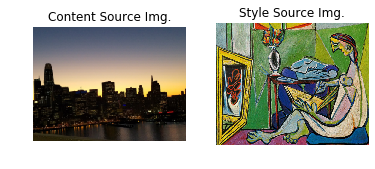

Iteration 0


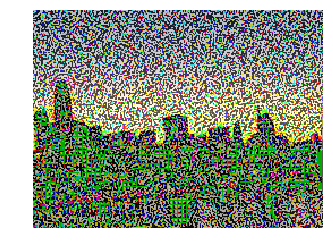

Iteration 100


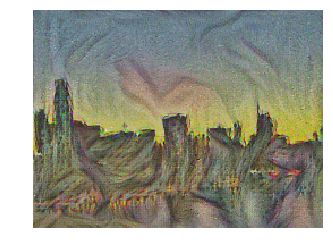

Iteration 200


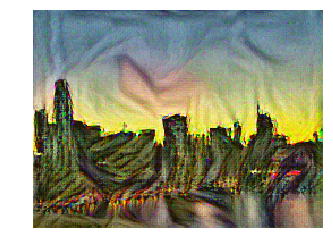

Iteration 299


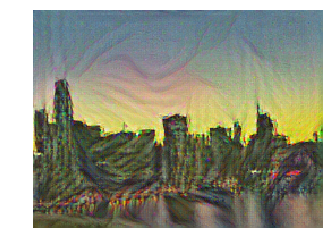

In [17]:
# The image generated is based

params1 = {
    'content_image' : 'styles/SFNight.jpg',
    'style_image' : 'styles/muse.jpg',
    'image_size' : 192,
    'style_size' : 512,
    'content_layer' : 3,
    'content_weight' : 5e-2, 
    'style_layers' : (1, 4, 6, 7),
    'style_weights' : (20000, 500, 12, 1),
    'tv_weight' : 5e-2
    }

style_transfer(**params1)

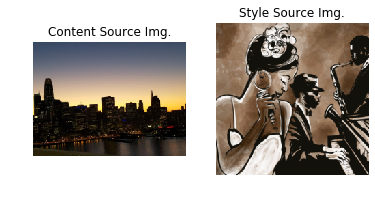

Iteration 0


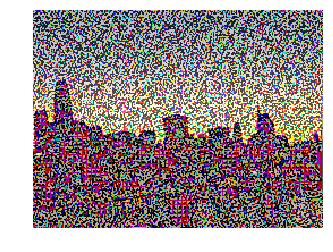

Iteration 100


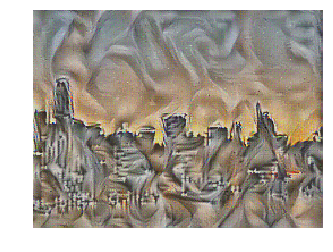

Iteration 200


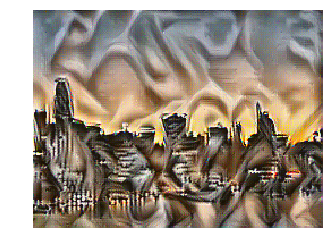

Iteration 299


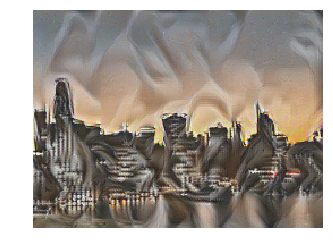

In [18]:
# Content_loss_test(answers['cl_out']) is < to a certain threesold
params2 = {
    'content_image':'styles/SFNight.jpg',
    'style_image':'styles/neg.jpg',
    'image_size':192,
    'style_size':224,
    'content_layer':3,
    'content_weight':3e-2,
    'style_layers':[1, 4, 6, 7],
    'style_weights':[200000, 800, 12, 1],
    'tv_weight':2e-2
}

style_transfer(**params2)